# DC Motor Simulation

Look at the dynamics_model.pdf for the explanation behind this code.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

[ 0.  2.] 0.01
[ 0.02  1.96] 0.01
[ 0.0376    1.920796] 0.01
[ 0.05304796  1.88237256] 0.01
[ 0.06656689  1.8447145 ] 0.01
[ 0.07835735  1.8078069 ] 0.01
[ 0.08859968  1.77163509] 0.01
[ 0.09745606  1.73618466] 0.01
[ 0.1050723   1.70144148] 0.01
[ 0.11157949  1.66739164] 0.01
[ 0.11709546  1.63402149] 0.01
[ 0.12172612  1.60131764] 0.01
[ 0.12556669  1.56926694] 0.01
[ 0.12870269  1.53785649] 0.01
[ 0.13121099  1.50707362] 0.01
[ 0.13316062  1.4769059 ] 0.01
[ 0.13461362  1.44734115] 0.01
[ 0.13562567  1.41836741] 0.01
[ 0.13624678  1.38997293] 0.01
[ 0.13652183  1.36214623] 0.01
[ 0.13649111  1.334876  ] 0.01
[ 0.13619076  1.30815118] 0.01
[ 0.13565319  1.28196092] 0.01
[ 0.13490748  1.25629457] 0.01
[ 0.13397968  1.2311417 ] 0.01
[ 0.13289313  1.20649207] 0.01
[ 0.13166874  1.18233565] 0.01
[ 0.13032522  1.1586626 ] 0.01
[ 0.12887932  1.13546328] 0.01
[ 0.12734602  1.11272824] 0.01
[ 0.1257387   1.09044821] 0.01
[ 0.12406932  1.06861409] 0.01
[ 0.12234853  1.047217  ] 0.01
[ 0.12058

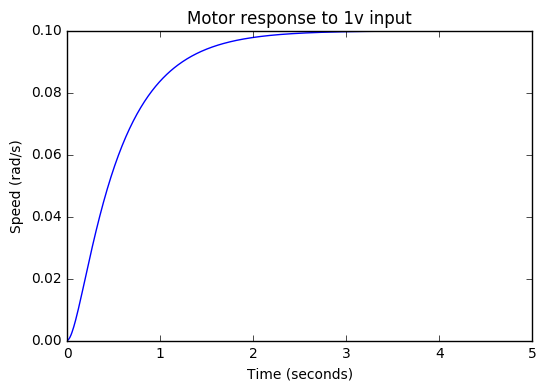

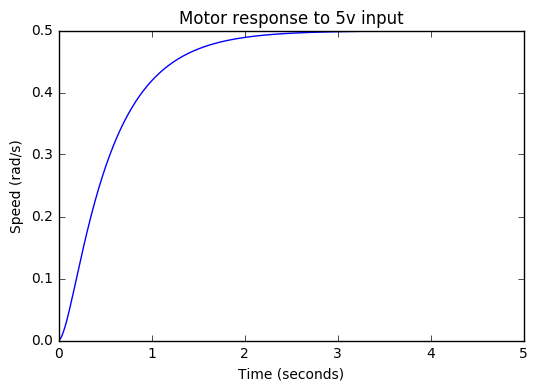

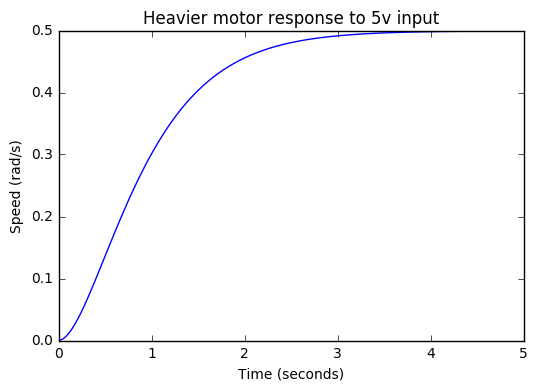

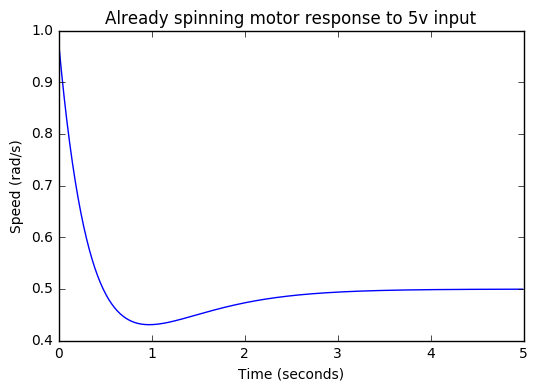

In [51]:
def simulate(V, J, b, K, R, L, theta_dot=0, i=0):
    # simulate T seconds
    T = 5
    dt = 0.01
    theta_dots = []
    ts = np.arange(0, T, dt)
    for t in ts:
        A = np.array([[-b/J,K/J],[-K/L,-R/L]])
        B = np.array([0, 1/L])
        x = np.array([theta_dot, i])
        w = V(t, i, theta_dot)
        x_dot = A@x+B*w
        theta_dot += (x_dot[0] * dt)
        i += (x_dot[1] * dt)
        print(x_dot, dt)
        theta_dots.append(theta_dot)
    
    return ts, theta_dots

def const_V(v):
    def _v(t, i, theta_dot):
        return v
    return _v

ts, theta_dots = simulate(const_V(1), J=0.01, b=0.1, K=0.01, R=1, L=0.5)
plt.figure()
plt.plot(ts, theta_dots)
plt.title("Motor response to 1v input")
plt.ylabel("Speed (rad/s)")
plt.xlabel("Time (seconds)")

ts, theta_dots = simulate(const_V(5), J=0.01, b=0.1, K=0.01, R=1, L=0.5)
plt.figure()
plt.plot(ts, theta_dots)
plt.title("Motor response to 5v input")
plt.ylabel("Speed (rad/s)")
plt.xlabel("Time (seconds)")

ts, theta_dots = simulate(const_V(5), J=0.05, b=0.1, K=0.01, R=1, L=0.5)
plt.figure()
plt.plot(ts, theta_dots)
plt.title("Heavier motor response to 5v input")
plt.ylabel("Speed (rad/s)")
plt.xlabel("Time (seconds)")

ts, theta_dots = simulate(const_V(5), J=0.05, b=0.1, K=0.01, R=1, L=0.5, theta_dot=1)
plt.figure()
plt.plot(ts, theta_dots)
plt.title("Already spinning motor response to 5v input")
plt.ylabel("Speed (rad/s)")
plt.xlabel("Time (seconds)")


plt.show()